In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score


# Preprocessing
## Import data

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [4]:
data = pd.read_csv('data/cleaned_5272.csv', header=0)

In [5]:
# show all columns
data.columns

Index(['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'discoverymethod',
       'disc_year', 'pl_orbper', 'pl_orbeccen', 'pl_orbsmax', 'pl_rade',
       'pl_bmasse', 'pl_insol', 'pl_eqt', 'st_spectype', 'st_teff', 'st_rad',
       'st_mass', 'st_met', 'st_metratio', 'st_logg', 'sy_dist',
       'planet_type'],
      dtype='object')

## Define features and target

In [6]:
# important variables
important_vars = ['pl_orbper', 'pl_orbeccen', 'pl_orbsmax', 'pl_rade', 'pl_bmasse']

# thrown variables
thrown_vars = ['pl_name', 'hostname', 'discoverymethod', 'disc_year', 'sy_dist']

# drop thrown variables
data.drop(thrown_vars, axis=1, inplace=True)

# define target variable
target = 'planet_type'

# split data into X and y according to target variable
X = data.drop(target, axis=1)[important_vars]
y = data[target]

## Encode categorical features

## Split into train and test sets

In [7]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# find categorical variables
is_categorical = X.columns.isin(['st_spectype', 'st_metratio'])

# Random Forest
Random forest does not support missing values

# GradientBoost 
Gradient Boost does not support missing values

# HistGradientBoost 

In [9]:
# use grid search to find best parameters
from sklearn.model_selection import RandomizedSearchCV

# define parameters
param_grid = {'learning_rate': [0.02, 0.05, 0.1, 0.2], 'max_iter': [20, 50, 100, 200], 'max_depth': [2, 4, 8, 16], 'l2_regularization': [0.0, 0.1, 0.5, 1.0]}

# define model
model = HistGradientBoostingClassifier(random_state=42)

# define grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [10]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 0.1, 0.5, 1.0],
                         'learning_rate': [0.02, 0.05, 0.1, 0.2],
                         'max_depth': [2, 4, 8, 16],
                         'max_iter': [20, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [11]:
grid_search.best_estimator_

HistGradientBoostingClassifier(l2_regularization=0.1, learning_rate=0.05,
                               max_depth=4, max_iter=200, random_state=42)

In [12]:
grid_search.best_params_

{'l2_regularization': 0.1,
 'learning_rate': 0.05,
 'max_depth': 4,
 'max_iter': 200}

In [13]:
grid_search.best_estimator_.score(X_test, y_test)

0.9744075829383886

In [14]:
mean_test_score = grid_search.cv_results_['mean_test_score'].reshape(4, 4, 4, 4)

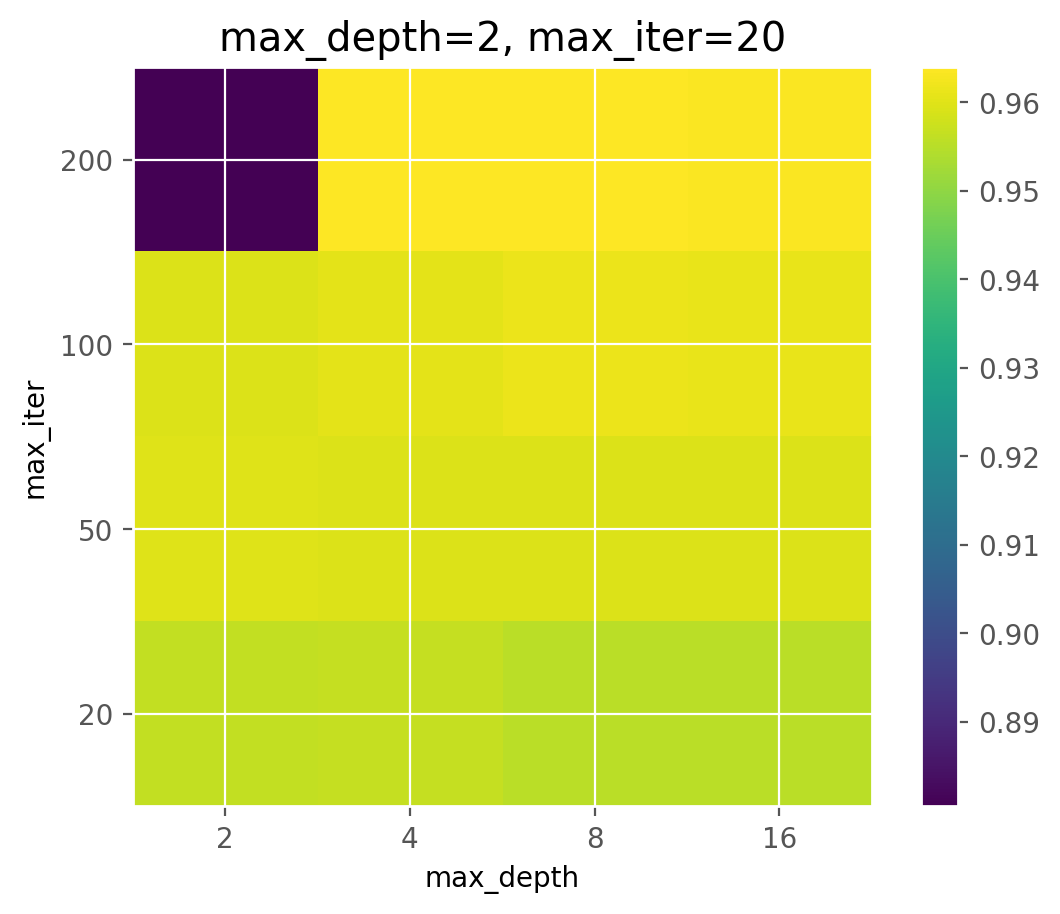

In [15]:
plt.imshow(mean_test_score[:, :, 0, 0].T, cmap='viridis', origin='lower')
plt.xticks(np.arange(4), param_grid['max_depth'])
plt.yticks(np.arange(4), param_grid['max_iter'])
plt.xlabel('max_depth')
plt.ylabel('max_iter')
plt.title('max_depth=2, max_iter=20')
plt.colorbar()
plt.show()

In [16]:
hgb = grid_search.best_estimator_

In [17]:
# train accuracy
print('Accuracy on training set: {:.3f}'.format(hgb.score(X_train, y_train)))

Accuracy on training set: 0.994


In [18]:
# compute test accuracy
y_pred = hgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.9744075829383886

In [19]:
hgb.classes_

array(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial',
       'Unknown'], dtype=object)

In [20]:
# confusion matrix
confusion_matrix(y_test, hgb.predict(X_test))

array([[330,   2,   1,   0,   0],
       [  0, 341,   2,   0,   0],
       [  0,  16, 310,   1,   0],
       [  0,   1,   2,  47,   0],
       [  0,   2,   0,   0,   0]])

In [21]:
# classification report
print(classification_report(y_test, hgb.predict(X_test)))

              precision    recall  f1-score   support

   Gas Giant       1.00      0.99      1.00       333
Neptune-like       0.94      0.99      0.97       343
 Super Earth       0.98      0.95      0.97       327
 Terrestrial       0.98      0.94      0.96        50
     Unknown       0.00      0.00      0.00         2

    accuracy                           0.97      1055
   macro avg       0.78      0.77      0.78      1055
weighted avg       0.97      0.97      0.97      1055



/Users/wang/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wang/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wang/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [22]:
# apply roc score 
roc_auc_score(y_test, hgb.predict_proba(X_test), multi_class='ovr')

0.9936107004095606

# XGBoost

In [23]:
# encode output variables
type_le = LabelEncoder()
y_train = type_le.fit_transform(y_train)
y_test = type_le.transform(y_test)

In [24]:
import xgboost as xgb

param_grid = {'learning_rate': [0.02, 0.05, 0.1], 'max_depth': [2, 4, 8], 'lambda': [0.0, 0.1, 0.5, 1.0]}
grid_search = GridSearchCV(xgb.XGBClassifier(eval_metric='mlogloss'), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [25]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'lambda': [0.0, 0.1, 0.5, 1.0],
                         'learning_rate': [0.02, 0.05, 0.1],
                         'max_depth': [2, 4, 8]},
             scoring='accuracy', verbose=1)

In [26]:
clf = grid_search.best_estimator_

Text(0.5, 1.0, 'Feature Importance')

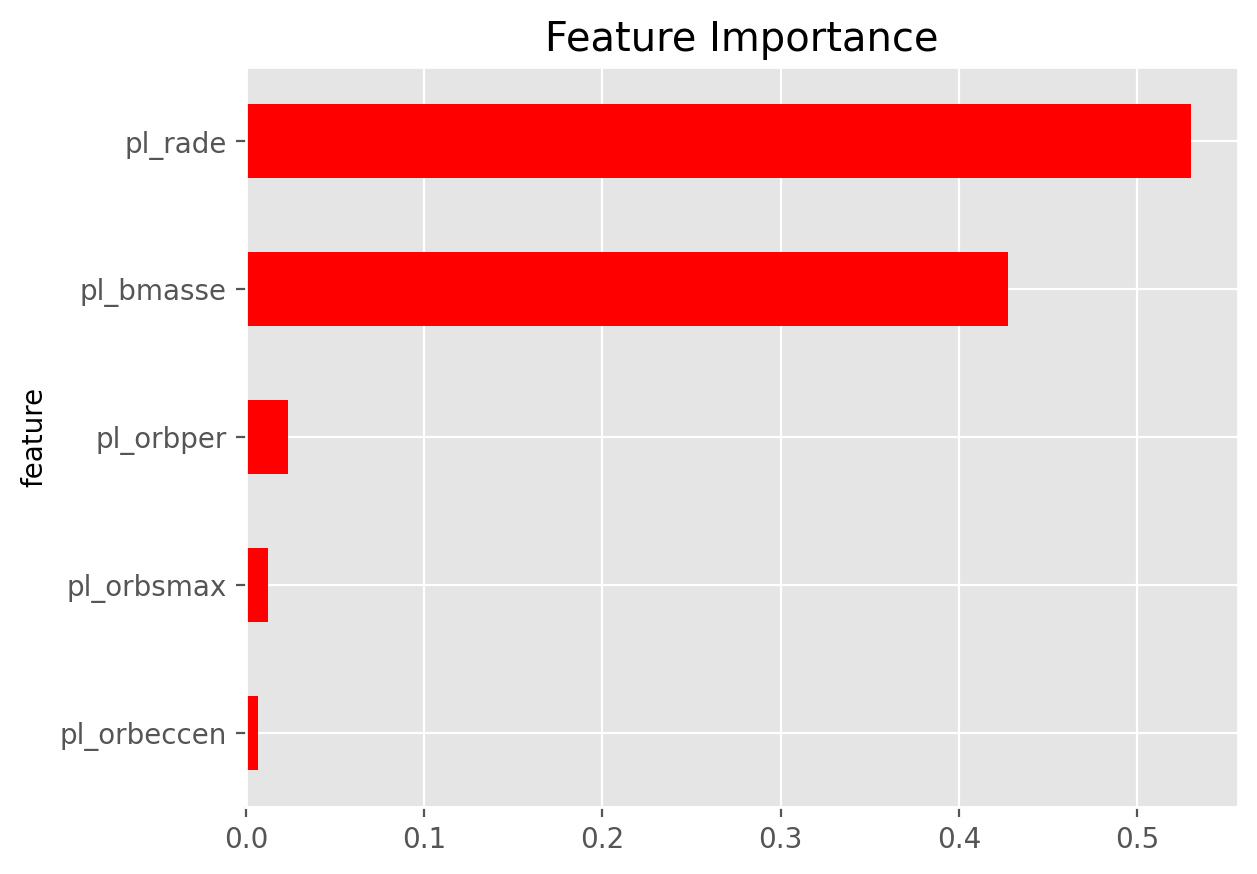

In [27]:
# create a dataframe 
feature_importance = pd.DataFrame({'feature': clf.feature_names_in_, 'importance': clf.feature_importances_})
# plot feature importance in hbar plots ranked by importance
feature_importance.sort_values(by='importance', ascending=True).plot(x='feature', y='importance', kind='barh', color='red', legend=False)
plt.title('Feature Importance')

In [28]:
# calculate accuracy
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9753554502369668

In [29]:
# confusion matrix
confusion_matrix(y_test, y_pred)

array([[328,   4,   1,   0,   0],
       [  0, 341,   2,   0,   0],
       [  0,  15, 311,   1,   0],
       [  0,   1,   0,  49,   0],
       [  0,   2,   0,   0,   0]])

# AdaBoost
AdaBoost does not support missing values